# Brain Tumor Detection

## Path Variables and constants

In [1]:
# Constants
TEST_SIZE = 0.10
VAL_SIZE = 0.10

# Path Variables
DATASET_FOLDER = 'datasets/'
MODELS_FOLDER = 'models/'
dataset_path = DATASET_FOLDER + 'brain_tumor_dataset/'

In [32]:
import random
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
from sklearn.metrics import classification_report

## Dataset loading and preprocessing
1. Load dataset
2. Study dataset
3. Preprocessing
4. Augmentation
6. Validation Train Test Split


In [3]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

# # augment data for the examples with label equal to 'yes' representing tumurous examples
# augment_data(file_dir=dataset_path + 'yes',n_generated_samples=6, save_to_dir=dataset_path+'yes_augmented')
# # augment data for the examples with label equal to 'no' representing non-tumurous examples
# augment_data(file_dir=dataset_path+'no', n_generated_samples=9, save_to_dir=dataset_path+'no_augmented')

In [51]:
def plot_image(image, title):
    plt.figure()
#     plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title(title)
    plt.show()

In [4]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


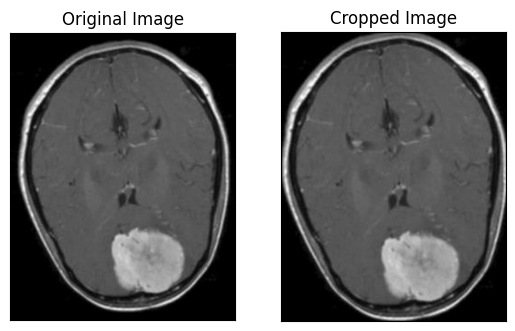

In [5]:
ex_img = cv2.imread(dataset_path + 'yes_augmented/aug_yes_6_0_663.jpg') #aug_yes_6_0_663.jpg
ex_crop_img = crop_brain_contour(ex_img, True)

In [6]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    y_count = 0
    
    for directory in dir_list:
        for filename in listdir(directory):
            if filename.find('.DS_Store') != -1:
                continue
                
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            y
            if directory.endswith('yes_augmented'):
                y_count += 1
                y.append([1])
            else:
                y.append([0])
                    
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [7]:
augmented_yes = dataset_path+ 'yes_augmented'
augmented_no = dataset_path+'no_augmented'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


In [8]:
def plot_sample_images(X, y, n=9):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
#         n_images = images[:n]
        n_images = random.choices(images, k = n)
        
        columns_n = 3
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

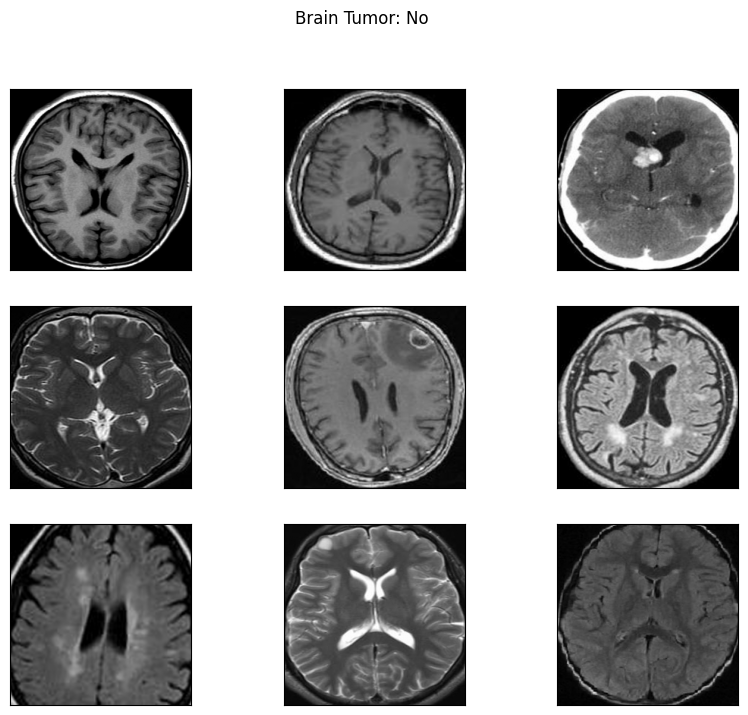

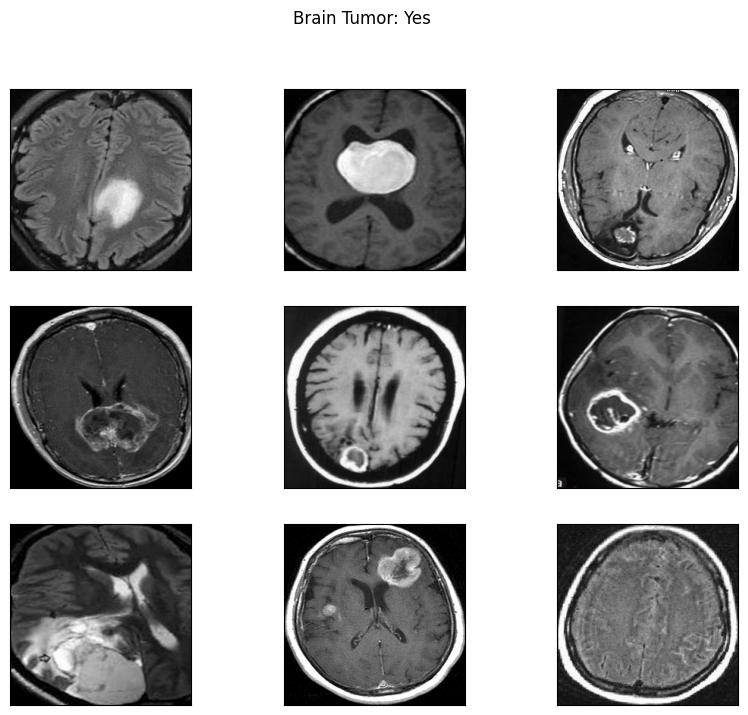

In [9]:
plot_sample_images(X, y)

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size = TEST_SIZE, 
                                                            stratify = y, 
                                                            random_state = 1)

# If we have larger dataset, we may also use val sets, but for now will stick to only train and test.

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size = VAL_SIZE, 
                                                            stratify = y_train_val,
                                                            random_state = 1)

In [11]:
print('Train split size: X - {}, y - {}'.format(X_train.shape, y_train.shape))
print('Validation split size: X - {}, y - {}'.format(X_val.shape, y_val.shape))
print('Test split size: X - {}, y - {}'.format(X_test.shape, y_test.shape))

Train split size: X - (1671, 240, 240, 3), y - (1671, 1)
Validation split size: X - (186, 240, 240, 3), y - (186, 1)
Test split size: X - (207, 240, 240, 3), y - (207, 1)


In [12]:
def init_model(input_dim):
    X_input = Input(input_dim)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [13]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=init_model(IMG_SHAPE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))


Epoch 1/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 978ms/step - accuracy: 0.5454 - loss: 1.2238 - val_accuracy: 0.6344 - val_loss: 0.6402
Epoch 2/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 957ms/step - accuracy: 0.7489 - loss: 0.4991 - val_accuracy: 0.7527 - val_loss: 0.5817
Epoch 3/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 971ms/step - accuracy: 0.7577 - loss: 0.5012 - val_accuracy: 0.7849 - val_loss: 0.5082
Epoch 4/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8413 - loss: 0.3972 - val_accuracy: 0.8011 - val_loss: 0.4830
Epoch 5/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 966ms/step - accuracy: 0.8540 - loss: 0.3440 - val_accuracy: 0.6882 - val_loss: 0.5752
Epoch 6/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8934 - loss: 0.2884 - val_accuracy: 0.8226 - val_loss: 0.4573
Epoch 7/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 977ms/step - accuracy: 0.8453 - loss: 0.3430 - val_accuracy: 0.7527 - val_loss: 0.4828
Epoch 8/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 967ms/step - accuracy: 0.8894 - loss: 0.2682 - val_accuracy: 

In [15]:
history = model.history.history

In [16]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

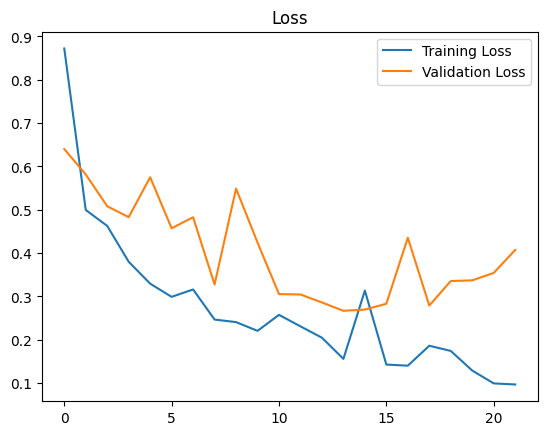

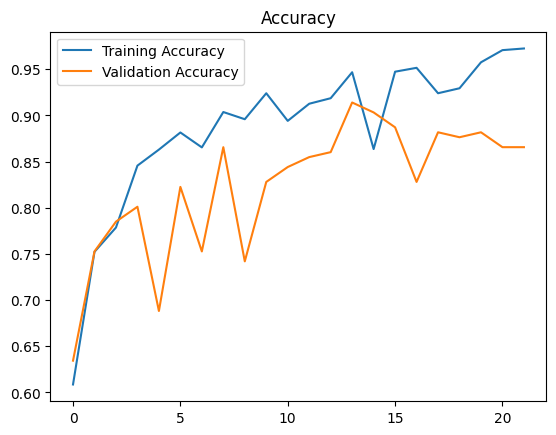

In [17]:
plot_metrics(history)

The model is performing well over 15 epochs, we may choose to stop training early or perform further fine-tuning. The validation accuracy is above 90% around 15 epocs. It decreases after 15 epochs, a possible reason is the model might have overfit. For now, we can proceed further with the model and predict on test dataset.

In [18]:
y_pred_scores = model.predict(X_test)
y_pred = (y_pred_scores >= 0.5).astype(int)
y_pred = [i[0] for i in y_pred]
y_test = [i[0] for i in y_test]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


In [33]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        98
           1       0.95      0.77      0.85       109

    accuracy                           0.86       207
   macro avg       0.87      0.86      0.86       207
weighted avg       0.88      0.86      0.86       207



The average recall of the model is about 86%, which is a reasonable result. We will now train the model with full data. 

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X, y=y, batch_size=32, epochs=15)

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8448 - loss: 0.4503
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 961ms/step - accuracy: 0.9687 - loss: 0.1124
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 951ms/step - accuracy: 0.9651 - loss: 0.0982
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 950ms/step - accuracy: 0.9523 - loss: 0.1253
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 957ms/step - accuracy: 0.9678 - loss: 0.1020
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 951ms/step - accuracy: 0.9620 - loss: 0.1077
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 952ms/step - accuracy: 0.9630 - loss: 0.1005
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 958ms/step - accuracy: 0.9584 - loss: 0.1189
Epoch 9/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 973ms/step - accuracy: 0.9816 - loss: 0.0637
Epoch 10/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 958ms/step - accuracy: 0.9855 - loss: 0.0601
Epoch 11/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9891 - loss: 0.0492
Epoch 12/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 958m

In [40]:
history = model.history.history

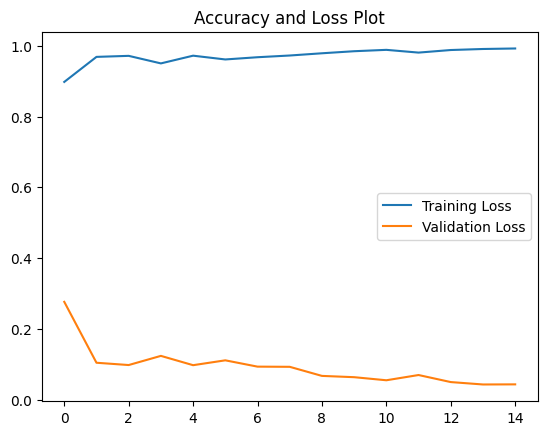

In [42]:
# Loss
plt.figure()
plt.plot(history['accuracy'], label='Training Loss')
plt.plot(history['loss'], label='Validation Loss')
plt.title('Accuracy and Loss Plot')
plt.legend()
plt.show()

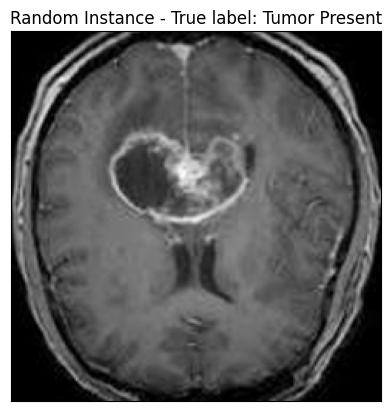

In [101]:
# Testing model with random instance from dataset

random_index = random.randint(0, len(X) - 1)
image = X[random_index]
label = 'Tumor Present' if y[random_index][0] == 1 else 'No Tumor Present'
plot_image(image, f'Random Instance - True label: {label}')


In [102]:
image = image.reshape(1, 240, 240, 3)
predicted_score = model.predict([image])[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [103]:
predicted_label = 'Tumor Detected' if predicted_score >= 0.5 else 'No Tumor Detected'
print(f'Model Prediction - {predicted_label}')

Model Prediction - Tumor Detected


In [98]:
import pickle

# Saving the model
dump = {
    'model' : model,
    'report' : report
}

filename = 'brain_tumor_nn.pkl'

pickle.dump(dump, open(MODELS_FOLDER+filename, 'wb'))